# Clustering example of data from MD simulation

## Using a clustering algorithm to find how many clusters we found in the simulation.

The simulation is the formation of micelles using MARTINI-coarse-grained in a MD simulation. Micelles are small aggregation of molecules that have an hydrophilic head and hydrophobic tail.

The idea is that we would like to know how many micelles are formed, but because they continuosly move in space and also merge and unmerge between them is difficult to track the exact number of micelles. 

One possible way to determine the number of micelles is to classify the spatial data into clusters and use a hierachical cluster algorithm couple to some distance criteria to determine the number of micelles.

The simulations data and analisis is derived from [my published work](https://doi.org/10.1039/C8CP04505D) in collaboration with Silvia Illia-Tuset and Jordi Faraudo from ICMAB-CSIC.  

<img src="WET/untitled.gif" width="700">

We are going to use **Numpy** for the arrays, **Scipy** for the hierachical clustering and **MDtraj** for loading the MD trajectory data

Check [MDtraj webpage](https://www.mdtraj.org/1.9.8.dev0/index.html#) for installation notes

In [1]:
import mdtraj as md
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import fcluster

We load the trajectory data using MDtraj. The simulation was done with [GROMACS](https://www.gromacs.org/) 

In [2]:
traj = md.load(['./WET/notwater-s.trr'],top='./WET/notwater.gro')
traj

<mdtraj.Trajectory with 41 frames, 5000 atoms, 1000 residues, and unitcells at 0x7eff31170f10>

Our molecule have 5 atom types and we selected all of them in the molecule for the clustering

In [3]:
ctab=traj.topology.select('name NC3 C1 C2 C3 C4')

Next we are going to center the coordinates and save an array for the positions and for the simulation box dimensions

In [4]:
traj.center_coordinates
tctab=traj.xyz[:,ctab,:] #positions
box=traj.unitcell_lengths #box dimensions

The system has [periodic boundary conditions](https://en.wikipedia.org/wiki/Periodic_boundary_conditions). This implies that when we do a distance calculation we need to have the box dimension for correcting the distance value. A quick and dirty trick to perform this correction is having an array with the same dimensions that our positions filled with the data for box dimension 

In [5]:
xbox=np.zeros((traj.n_frames , traj.n_atoms)) #We create an array of the same dimension that our positions
ybox=np.zeros((traj.n_frames , traj.n_atoms))
zbox=np.zeros((traj.n_frames , traj.n_atoms))
nclust=np.zeros((traj.n_frames))


for i in range(0,traj.n_frames): #we fill the arrays with the box dimensions
    xbox[i,...]=box[i,0]
    ybox[i,...]=box[i,1]
    zbox[i,...]=box[i,2]    

From the calculation we are going to save the number of clusters and the cluster size distribution for each frame

In [6]:
#Files to save data
file1= open('nclust.dat', 'a')
file2= open('clustdist.dat', 'a')

## Hierachical clustering
Finally we do a loop over the trajectory frames that:
- Calculate the distance between each atom
- Correct for the periodic boundary conditions
- Reshape the distance matrix
- Hierachical clustering
- Save data

To **classify clusters** we are going to use the Farthest Point Algorithm. In Scipy this can be done by using the cluster.hierarchy.linkage function and the "complete" option. We choose a distance of 9 nm since the [approximate diameter for these micelles is ~4.5 nm](https://doi.org/10.1039/C8CP04505D)


In [7]:
for i in range(0,traj.n_frames):
    
    #distance between atoms
    dx = np.subtract.outer(tctab[i,:,0],tctab[i,:,0])
    dy = np.subtract.outer(tctab[i,:,1],tctab[i,:,1])
    dz = np.subtract.outer(tctab[i,:,2],tctab[i,:,2])
    
    #periodic boundary conditions fix
    dx = dx - xbox[i,:]*np.around(dx/xbox[i,:])
    dy = dy - ybox[i,:]*np.around(dy/ybox[i,:])
    dz = dz - zbox[i,:]*np.around(dz/zbox[i,:])
    
    #distance matrix (square root (distance x + distance y + distance z))
    distance = np.array( np.sqrt( np.square(dx) + np.square(dy) + np.square(dz)))
    
    #reshape of distance matrix from triangular to square
    distancefull=squareform(distance, checks=False)
    
    #Hierachical clustering 
    clust=scipy.cluster.hierarchy.linkage(distancefull,'complete')
    
    max_d = 9 #distance cutoff for clustering based on experimental data
    
    #Identify cluster based on distance criteria
    clustdist = fcluster(clust, max_d, criterion='distance')
    
    #maximum number of cluster = number of micelles in the simulation
    nclust[i]=np.amax(clustdist)
    nclustint=np.amax(clustdist)
   
    #distribucion de clusters = size distribution of clusters
    clustsize=np.histogram(clustdist,bins=nclustint-1)
    
    #save size distribution for each frame into a file
    np.savetxt(file2, clustsize[0])

#save maximum number of micelles per frame into a file    
np.savetxt(file1, nclust[:])

We can plot the dendrogram for the last frame

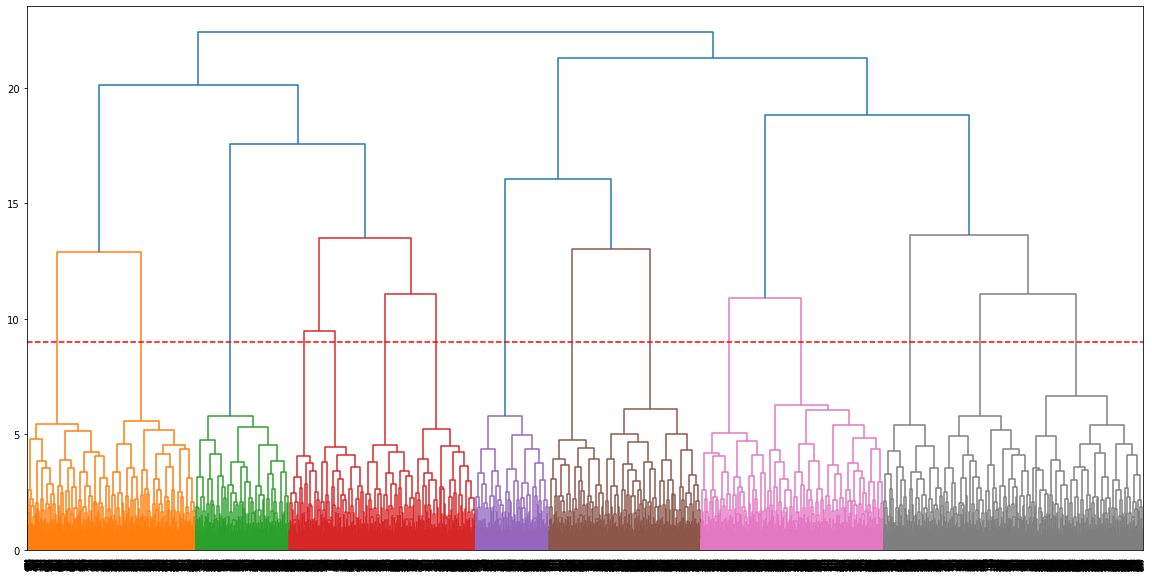

In [8]:
fig = plt.figure(figsize=(20, 10))
dn=scipy.cluster.hierarchy.dendrogram(clust)
plt.axhline(y=9, color='r', linestyle='--')
plt.show()

We can also plot the number of clusters that fulfill the distance criteria per frame. This is the **number of micelles** in our simulation per frame. 

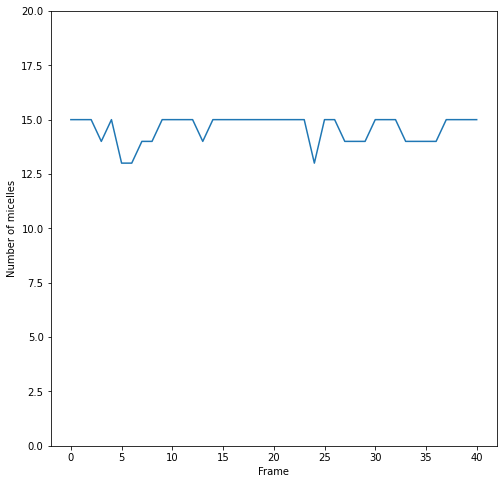

In [9]:
fig = plt.figure(figsize=(8, 8))
plt.plot(nclust)
plt.ylim([0, 20])
plt.ylabel("Number of micelles")
plt.xlabel("Frame")
plt.show()

In [10]:
np.average(nclust)

14.585365853658537

The average number of micelles is 14.58.  We also see that the tendency is stable which indicates that the simulations are in equilibrium 

The size for each of the 15 micelles in the last frame are the following

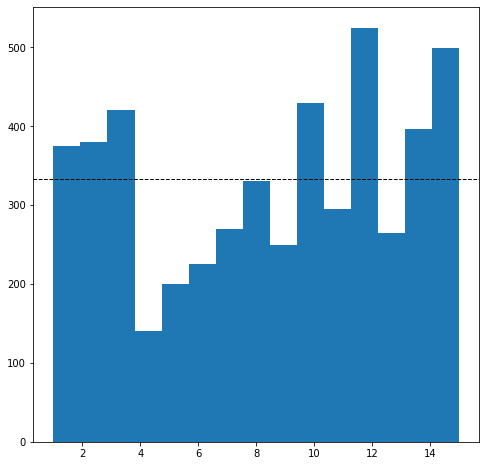

In [11]:
fig = plt.figure(figsize=(8, 8))
y,bins,patches=plt.hist(clustdist,bins=15)
plt.axhline(y.mean(), color='k', linestyle='dashed', linewidth=1)
plt.show()

In [12]:
y.mean()/5

66.66666666666666

Each molecule has 5 atoms so in average the micelles have 66 molecules. [The reported number from experiments is ~75 molecules per micelle](https://doi.org/10.1515/chem-2015-0103)

Finally we can also do a size distribution over all the micelles found during the trajectory

In [53]:
sizetraj=np.loadtxt("clustdist.dat")
sizetrajmol=sizetraj/5 #Values divided by number of atoms per molecule

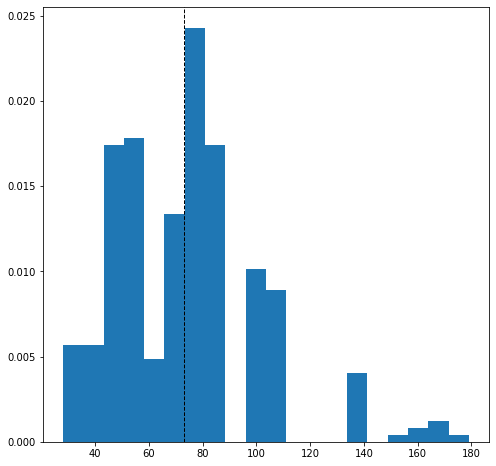

72.87461773700306

In [54]:
fig = plt.figure(figsize=(8, 8))
y,bins,patches=plt.hist(sizetrajmol,bins=20,density=True)
plt.axvline(sizetrajmol.mean(), color='k', linestyle='dashed', linewidth=1)
plt.show()
sizetrajmol.mean()

We can see from the distribution along the trajectory the following:
- the mean is around the experimental value and the distribution resemble an exponentially modified Gaussian distribution.

- the algorithm found very large micelles (~140-180 atoms). This is rather unfrequent but represents the merging/unmerging of micelles that occurs during the simulation.